You work at the oil extraction company OilyGiant. Your task is to find the best places to open 200 new oil wells.

To complete this task, you will have to perform the following steps:
 
- Read the files with the parameters collected from oil wells in the selected region: crude oil quality and reserve volume.
- Create a model to predict the volume of reserves in new wells.
- Choose the oil wells that have the highest estimated values.
- Choose the region with the highest total profit for the selected oil wells.
- You have data on crude oil samples from three regions. The parameters of each oil well in the region are already known. Create a model that helps choose the region with the highest profit margin. Analyze potential benefits and risks using the bootstrapping technique.

## Importing libraries

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importing datasets

In [101]:
region1 = pd.read_csv('D:/Tripleten/datasets/geo_data_0.csv')
region2 = pd.read_csv('D:/Tripleten/datasets/geo_data_1.csv')
region3 = pd.read_csv('D:/Tripleten/datasets/geo_data_2.csv')

I listed the regions in a list called databases, this code will be reused for the rest of the code. 

In [125]:
databases = [region1,region2, region3]

for region in databases:
    print('____________________')
    print(region.info(), end='\n\n')
    textual_data = region[region['product'].apply(lambda x: isinstance(x, str))]
    print(f"Found text values :{textual_data.values}",end='\n\n')

____________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Found text values :[]

____________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Found text values :[]

____________________
<class 'pan

The columns are named correctly, not nan values  nor textual values in the column 'product' were identified

In [126]:
for region in databases:
    print (region.head(2), end='\n\n')

      id        f0        f1       f2     product
0  txEyH  0.705745 -0.497823  1.22117  105.280062
1  2acmU  1.334711 -0.340164  4.36508   73.037750

      id         f0        f1        f2    product
0  kBEdx -15.001348 -8.276000 -0.005876   3.179103
1  62mP7  14.272088 -3.475083  0.999183  26.953261

      id        f0        f1        f2    product
0  fwXo0 -1.146987  0.963328 -0.828965  27.758673
1  WJtFt  0.262778  0.269839 -2.530187  56.069697



Column 'id', will not be relevant for the machine learning modeling. I'll proceed analyzing the values with charts

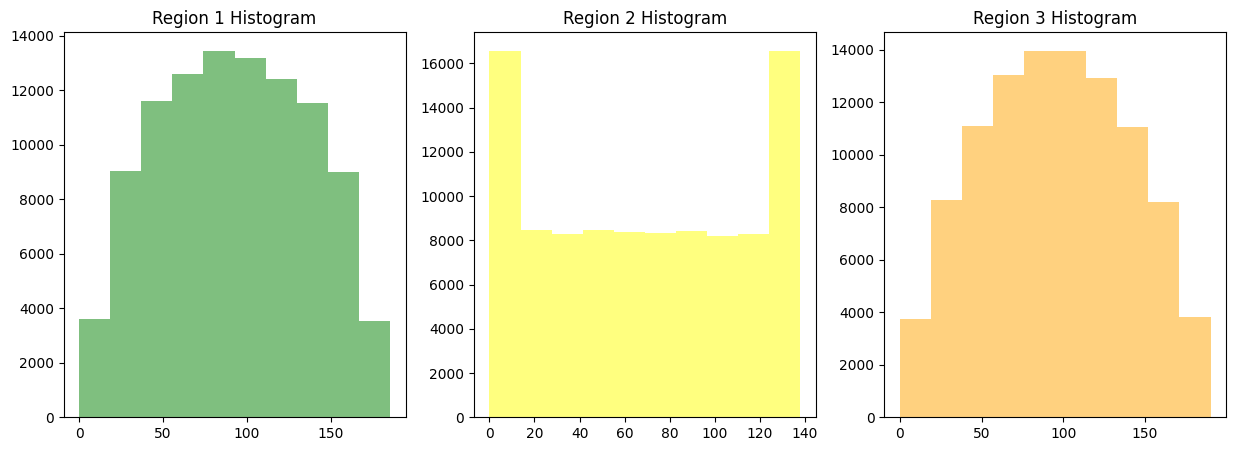

In [127]:
colors= ['green','yellow','orange']
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, region in enumerate(databases):
    row = 0
    col = i % 3 
    axs[col].hist(region['product'], color=colors[i], alpha=0.5)
    axs[col].set_title(f'Region {i+1} Histogram')

Region 1 and region 3 presents a normal distribution, however region 2 shows a bimodal distribution we may analyze in deep this skewed distribution.

In [128]:
for i, region in enumerate(databases):
	print(f'region {i+1}')
	print(f'unique values:{region['product'].nunique()}')
	print(f'shape of the column {region['product'].shape[0]}', end='\n\n')

region 1
unique values:100000
shape of the column 100000

region 2
unique values:12
shape of the column 100000

region 3
unique values:100000
shape of the column 100000



We found biased information in region 2, the values should be continuous not discrete, maybe the distribution was rounded.

In [129]:
region2['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

The distribution was not rounded, we are seeing some discrepancies with this dataset. In a real case, our superior should be informed abouth the discrepancy or the provider should be contacted in order to determined how can be fixed the error. I'll proceed with the dataset with no more changes. 

In [131]:
def plot_scatter_wells(real, predicted, region):
	'''This function will create an scatter chart to compare the predicted values vs the real values.'''
	plt.figure(figsize=(10,5))
	plt.scatter(x=np.arange(0,25000), y=[real])
	plt.scatter(x=np.arange(0,25000), y=[predicted], alpha=0.3)
	plt.title(f'Value distribution for region {region+1}')
	plt.legend(['Validation Values', 'Predicted Values'])
	plt.show()

In [133]:
def model_training( databases ):
	'''This function will train a Linear regression model, will use a distribution of 75% training, 25% testing and will return; the predicted
	values, the real values and the RMSE'''
	region_y_test = []
	region_y_predictions = []
	region_rmse = []

	for region in databases:
		target = region['product']
		features = region[['f0','f1','f2']]
		x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1234)
		model = LinearRegression()
		model.fit(x_train, y_train)
		y_predict = model.predict(x_test)
		
		mse = mean_squared_error(y_test,y_predict)
		rmse = np.sqrt(mse)

		region_rmse.append(rmse)
		region_y_test.append(y_test)
		region_y_predictions.append(y_predict)
		
	return region_y_test, region_y_predictions, region_rmse


In [134]:

def profit(real, prediction):
	'''The profit function will calculate the reserved volume for the top 200 petroleum wells, it will also calculate the 
	  potential profit considering an initial investment of 100 millions (it will return total_reserved_volume and potential_profit)'''
	cost_of_goods = 100000000
	wells = 200
	break_even = cost_of_goods/wells
	minimum_to_produce = break_even/4500

	profit_df = pd.DataFrame({"real_prod":real,"pred_product":prediction})
	
	top_200 = profit_df.sort_values(by='pred_product', ascending=False)
	top_200 = top_200.head(200)

	total_reserved_volume = top_200['pred_product'].sum()
	potential_profit = (total_reserved_volume * 4500) - cost_of_goods

	return total_reserved_volume, potential_profit


In [150]:
def bootstrapping(profit_df):
    '''The bootstrapping function will calculate the Average profit, the risk of loss, and the confidence interval'''
    state = np.random.RandomState(12345)
    profits = []

    for i in range(1000):
        sample = profit_df['real_prod'].sample(frac=1, replace=True, random_state=state)
        pred_sample = profit_df['pred_product'][sample.index]
        total_reserve_volume, potential_profit = profit(sample, pred_sample)
        profits.append(potential_profit)

    avg_profit = np.mean(profits)
    upper,lower = np.percentile(profits, [2.5, 97.5])
    risk_of_loss = np.mean(np.array(profits) < 0)
    risk_of_loss_percentage = risk_of_loss * 100

    print(f'Average profit: {avg_profit:.2f}')
    print(f'95% Confidence Interval: [{lower:.2f} , {upper:.2f}]')
    print(f'Risk of loss (%): {risk_of_loss_percentage:.2f}')


In [163]:
def main(n_region):
	'''This is the main function who will execute all the previous functions, showing the final results for the typed region.
	 The elements to be shown will be; RMS, Total mean reserved volume, Top 200 wells mean Reserved Volume, Potential Profit , Average
	  Confidence and Risk of loss '''
	
	y_tests, y_predictions, rmse = model_training(databases)
	profit_df = pd.DataFrame({"real_prod":y_tests[n_region],"pred_product":y_predictions[n_region]})
	reserved_volume, potential_profit  = profit(y_tests[n_region],y_predictions[n_region])

	print(f'___________________________________')
	print(f'MODEL PREDICTION RESULTS FOR REGION {n_region+1}')
	print(f'RMSE: {rmse[n_region]:.2f}')
	print(f'Max reserved volume {y_tests[n_region].max()}')
	print(f'Min reserved volume {y_tests[n_region].min()}')
	print(f'Mean reserved volume: {y_predictions[n_region].mean():.2f}')
	print(f'Reserved volume for 200 wells: {reserved_volume}')
	print(f'Potential Profit {potential_profit:.2f}')
	bootstrapping(profit_df)	
	plot_scatter_wells(y_tests[n_region], y_predictions[n_region],n_region )
	


## Analysis for Region 1

___________________________________
MODEL PREDICTION RESULTS FOR REGION 1
RMSE: 37.56
Max reserved volume 185.3626902521712
Min reserved volume 0.0
Mean reserved volume: 92.43
Reserved volume for 200 wells: 30849.146097992285
Potential Profit 38821157.44
Average profit: 38829691.82
95% Confidence Interval: [39791503.21 , 37846322.70]
Risk of loss (%): 0.00


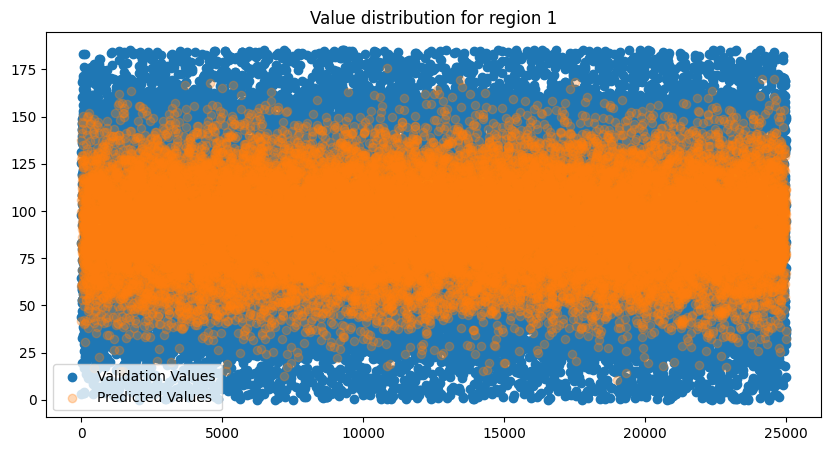

In [164]:
main(0)

As we saw in the histograms, region 1 had a normal distribution, now the model has been trained, we can see a Root Mean Square error of 37.56 which is relatively good considering the maximum and minimum values of the target.The mean reserved volume is 92.43 (thousand barrels).

When focusing in the best petroleum wells we got a total production of 30,849.14 (thousand of barrels) which are more than the 22,222.22 necessary to cover the investment of 100 millions.

According to the analysis, we are expecting a potential profit of 38821157.44 for the 200 selected wells. To get a better stability of the value we ran 1000 samples (bootstrapping) getting an average profit of 38829691.82, pretty close to the potential profit.

Finally we have an confidence interval between $37846322.70 and $39791503.21 and a Risk of loss of 0%


## Analysis for Region 2

___________________________________
MODEL PREDICTION RESULTS FOR REGION 2
RMSE: 0.89
Max reserved volume 137.94540774090564
Min reserved volume 0.0
Mean reserved volume: 68.80
Reserved volume for 200 wells: 27738.858152450288
Potential Profit 24824861.69
Average profit: 24824082.96
95% Confidence Interval: [24877317.29 , 24773643.72]
Risk of loss (%): 0.00


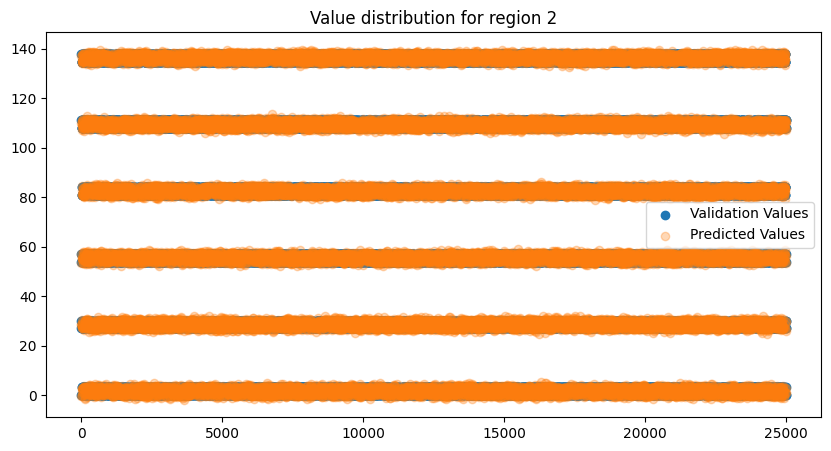

In [165]:
main(1)

As we saw in the histograms, region 2 had a skewed distribution, now the model has been trained, we can see a Root Mean Square error of 0.89 which could be considering almost perfect, however since the histogram chart we identified something wrong and unusual with this dataset. The maximum and minimum values of the target are 137.94 and 0, also the majority of the values are placed in those values.The mean reserved volume is 68.80 (thousand barrels).

When focusing in the best petroleum wells we got a total production of 27,738.85 (thousand of barrels) which are little more than the 22,222.22 necessary to cover the investment of 100 millions.

According to the analysis, we are expecting a potential profit of 24824861.69 for the 200 selected wells. To get a better stability of the value we ran 1000 samples (bootstrapping) getting an average profit of 24824082.96, pretty close to the potential profit.

Finally we have an confidence interval between $24773643.72 and $24877317.29 and a Risk of loss of 0%

## Analysis for Region 3

___________________________________
MODEL PREDICTION RESULTS FOR REGION 3
RMSE: 40.10
Max reserved volume 190.01098161509907
Min reserved volume 0.0193268852621888
Mean reserved volume: 94.92
Reserved volume for 200 wells: 29996.330455486383
Potential Profit 34983487.05
Average profit: 34958535.63
95% Confidence Interval: [36010051.03 , 33967265.11]
Risk of loss (%): 0.00


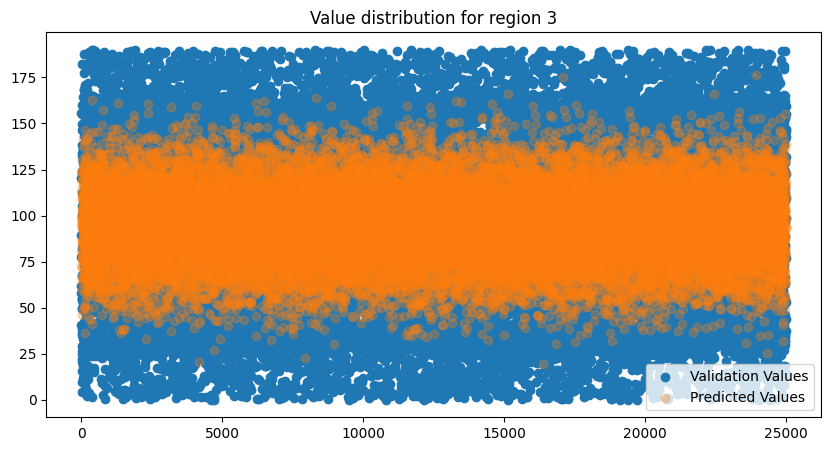

In [166]:
main(2)

As we saw in the histograms, region 3 had a normal distribution, now the model has been trained, we can see a Root Mean Square error of 40.10 which is relatively good considering the maximum and minimum values of the target.The mean reserved volume is 94.92 (thousand barrels).

When focusing in the best petroleum wells we got a total production of 29,996.33 (thousand of barrels) which are more than the 22,222.22 necessary to cover the investment of 100 millions.

According to the analysis, we are expecting a potential profit of 34983487.05 for the 200 selected wells. To get a better stability of the value we ran 1000 samples (bootstrapping) getting an average profit of 34958535.63, pretty close to the potential profit.

Finally we have an confidence interval between $33967265.11 and $36010051.03 and a Risk of loss of 0%

## Conclusion


According with the previous data, Region 1 should be considered as the best option to invest, 